# Tune the aerosol forcing to CMIP6 models

In [1]:
import iris
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import warnings
import iris.quickplot as qp
import glob
import json
import urllib
import os
from iris.experimental.equalise_cubes import equalise_attributes
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.stats import gaussian_kde
import matplotlib.gridspec as gridspec

Includes nitrate?
1. CanESM5: No (personal communication with Jason Cole, and [Swart et al 2019](https://gmd.copernicus.org/articles/12/4823/2019/gmd-12-4823-2019.html) does not mention nitrate as an aerosol species)
1. E3SM: No (Wang et al. 2019)[https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019MS001851]
1. GFDL-CM4 Yes. Model metadata confirms the atmospheric component is AM4.1, which does. [Horowitz et al 2020](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2019MS002032)
1. GFDL-ESM4 Yes. (Dunne et al 2020)[https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019MS002015]
1. GISS: physics_version=3 definitely. physics_version=1 not clear, but I think so, at least offline [Kelley et al. 2020](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2019MS002025)
1. HadGEM3: Don't think so. I read somewhere that it explicitly did not. This paper does not say that it does: [Mulcahy et al 2018](https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2018MS001464)
1. IPSL: I think so. Boucher is silent on aerosol treatment, LMDZ-6A the atmospheric component does: [Hourdin et al 2020](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2019MS001892)
1. MIROC6: No [Tatebe et al 2019](https://gmd.copernicus.org/articles/12/2727/2019/)
1. MRI: No [Yukimoto et al 2019](https://www.jstage.jst.go.jp/article/jmsj/97/5/97_2019-051/_pdf/-char/en)
1. NorESM2: No [Kirkevag et al 2018](https://gmd.copernicus.org/articles/11/3945/2018/gmd-11-3945-2018.pdf)
1. UKESM: As HadGEM3

In [2]:
def check_and_download(filepath, url):
    """Checks prescence of a file and downloads if not present.

    Inputs
    ------
        filepath : str
            filename to download to
        url :
            url to download from
    """
    if not os.path.isfile(filepath):
        urllib.request.urlretrieve(url, filepath)
    return

In [3]:
pl.rcParams['figure.figsize'] = (12/2.54, 12/2.54)
pl.rcParams['font.size'] = 8
pl.rcParams['font.family'] = 'Arial'
pl.rcParams['xtick.direction'] = 'out'
pl.rcParams['xtick.minor.visible'] = True
pl.rcParams['ytick.minor.visible'] = True
pl.rcParams['xtick.direction'] = 'in'
pl.rcParams['ytick.direction'] = 'in'
pl.rcParams['ytick.right'] = True
pl.rcParams['xtick.top'] = True
pl.rcParams['figure.dpi'] = 96

In [4]:
warnings.simplefilter('ignore')

In [5]:
def format_cube(cube, field, filename):
    """
    This dataset is a raw dump of our archived data.
    As such we need to do some metadata parsing to make our lives easier.
    In this case we're just going to add an extra 'realization' coordinate,
    but we can put anything in here, as long as a cube is returned at the end.
    """
    if not cube.coords('realization'):
        realization = int(filename.split('/')[9][1])
        realization_coord = iris.coords.AuxCoord(
            realization, standard_name='realization', var_name='realization')
        cube.add_aux_coord(realization_coord)
        return cube

This next cell relies on the pre-generated APRP results

In [6]:
cubes = {}
models = [
    'CanESM5', 
    'E3SM', 
    'GFDL-CM4', 
    'GFDL-ESM4', 
    'GISS-E2-1-G',
    'HadGEM3-GC31-LL',
    'IPSL-CM6A-LR',
    'MIROC6',
    'MRI-ESM2-0',
    'NorESM2-LM',
    'UKESM1-0-LL'
]

for model in models:
    cubes[model] = {}
    print(model)
    for var in ['aprp_ERFariSW', 'aprp_ERFariLW', 'aprp_ERFaciSW', 'aprp_ERFaciLW', 'aprp_albedo', 'aprp_t9', 'erf_sw', 'erf_lw', 'erf']:
        filenames = glob.glob(
            '../data_input/rfmip_aprp/%s/r?i?p?f?/%s.nc' % (model,var))
        cubes[model][var] = iris.load_cube(filenames, callback=format_cube)
        if cubes[model][var].ndim == 2:
            cubes[model][var] = cubes[model][var].collapsed(['realization'], iris.analysis.MEAN)
        if model=='E3SM':
            cubes[model][var] = cubes[model][var] * (-1)

CanESM5
E3SM
GFDL-CM4
GFDL-ESM4
GISS-E2-1-G
HadGEM3-GC31-LL
IPSL-CM6A-LR
MIROC6
MRI-ESM2-0
NorESM2-LM
UKESM1-0-LL


In [7]:
colors = {
    'CanESM5'    :  'red',#'#1e4c24',
    'E3SM'       : 'darkorange',
    'GFDL-ESM4'  : 'yellowgreen', 
    'GFDL-CM4'   : 'yellow',#'green',
    'GISS-E2-1-G':  'green',#'#771d7b',
    'HadGEM3-GC31-LL': 'turquoise',
    'IPSL-CM6A-LR': 'teal',
    'MIROC6'     :  'blue',#b85fb7',
    'MRI-ESM2-0' : 'blueviolet',
    'NorESM2-LM' :  'purple',#'red',
    'UKESM1-0-LL': 'crimson',
    'mean'       : 'black',
    'AR5'         : '0.6',
    'AR6'         : '0.3',
    'Lund'        : 'pink',
}

linestyles = {
    'CanESM5'    :  '-',#'#1e4c24',
    'E3SM'       : '-',
    'GFDL-ESM4'  : '-', 
    'GFDL-CM4'   : '-',#'green',
    'GISS-E2-1-G':  '-',#'#771d7b',
    'HadGEM3-GC31-LL': '-',
    'IPSL-CM6A-LR': '-',
    'MIROC6'     :  '-',#b85fb7',
    'MRI-ESM2-0' : '-',
    'NorESM2-LM' :  '-',#'red',
    'UKESM1-0-LL': '-',
    'mean'       : '-',
    'AR5'         : '-',
    'AR6'         : '-',
    'Lund'        : '-',
}

endyear = {
    'CanESM5'    : 2100,
    'MIROC6'     : 2100,
    'NorESM2-LM' : 2100,
    'GISS-E2-1-G': 2100,
    'HadGEM3-GC31-LL': 2099,
    'GFDL-CM4'   : 2100,
    'E3SM'       : 2014,
    'UKESM1-0-LL': 2014,
    'GFDL-ESM4'  : 2014,
    'IPSL-CM6A-LR': 2100,
    'MRI-ESM2-0' : 2014,
}

startyear = {
    'CanESM5'    : 1850,
    'MIROC6'     : 1850,
    'NorESM2-LM' : 1850,
    'GISS-E2-1-G': 1850,
    'HadGEM3-GC31-LL': 1850,
    'GFDL-CM4'   : 1850,
    'E3SM'       : 1870,
    'GFDL-ESM4'  : 1850,
    'UKESM1-0-LL': 1850,
    'IPSL-CM6A-LR': 1850,
    'MRI-ESM2-0': 1850,
}

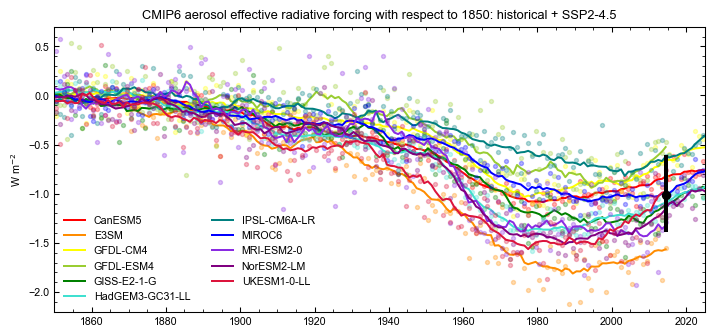

In [8]:
# maybe add AR5, Lund, and 2014 ERF to this
fig, ax = pl.subplots(figsize=(19/2.54,9/2.54))
for model in models:
    ax.plot(np.arange(startyear[model]+0.5,endyear[model]+1), cubes[model]['erf'].data, '.', lw=0, alpha=0.3, color=colors[model])
    ax.plot(np.arange(startyear[model]+0.5-10,endyear[model]+1), savgol_filter(np.concatenate((np.zeros(10), cubes[model]['erf'].data, cubes[model]['erf'].data[-1]*np.ones(10))), 11, 1)[:-10]
, color=colors[model], label=model, ls=linestyles[model])
ax.set_xlim(1850,2025)
ax.set_ylim(-2.2,0.7)
ax.plot(2014.5,-1.01,'ko')
ax.plot((2014.5,2014.5),(-0.63,-1.37),'k',lw=3,solid_joinstyle='bevel')
ax.legend(ncol=2, frameon=False)
ax.set_title('CMIP6 aerosol effective radiative forcing with respect to 1850: historical + SSP2-4.5')
ax.set_ylabel('W m$^{-2}$')
fig.tight_layout()
pl.savefig('../figures/figure1.png', dpi=300)
pl.savefig('../figures/figure1.pdf')

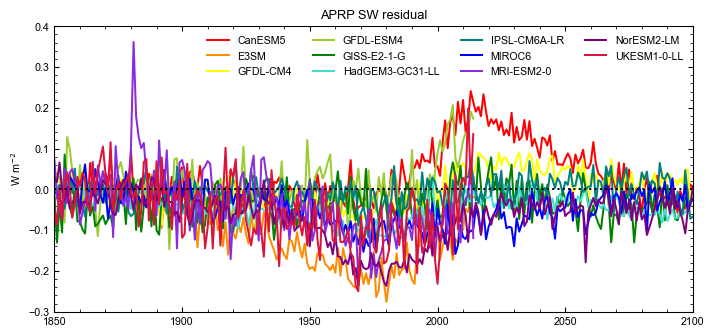

In [9]:
fig, ax = pl.subplots(figsize=(19/2.54, 9/2.54))
for model in models:
    #ax.plot(np.arange(1850,endyear[model]+1), cubes[model]['erf_sw'].data-cubes[model]['aprp_ERFariSW'].data-cubes[model]['aprp_ERFaciSW'].data-cubes[model]['aprp_albedo'].data, label=model, color=colors[model])
    ax.plot(np.arange(startyear[model],endyear[model]+1), cubes[model]['erf_sw'].data-cubes[model]['aprp_ERFariSW'].data-cubes[model]['aprp_ERFaciSW'].data, label=model, color=colors[model])
ax.set_xlim(1850,2100)
ax.set_ylabel('W m$^{-2}$')
ax.set_title('APRP SW residual')
ax.legend(frameon=False, ncol=4);
ax.set_ylim(-.3,.4)
ax.axhline(0, ls=':', color='k')
pl.tight_layout();
pl.savefig('../figures/figureS1.png', dpi=300)
pl.savefig('../figures/figureS1.pdf')

CanESM5
E3SM
GFDL-CM4
GFDL-ESM4
GISS-E2-1-G
HadGEM3-GC31-LL
IPSL-CM6A-LR
MIROC6
MRI-ESM2-0
NorESM2-LM
UKESM1-0-LL


Text(0, 0.5, 'W m$^{-2}$')

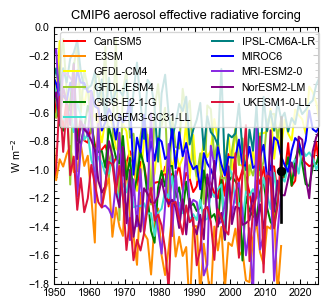

In [10]:
# maybe add AR5, Lund, and 2014 ERF to this
fig, ax = pl.subplots(figsize=(9/2.54,9/2.54))
for model in models:
    print(model)
    ax.plot(np.arange(startyear[model]+.5,endyear[model]+1), 
            cubes[model]['aprp_ERFariSW'].data+
            cubes[model]['aprp_ERFariLW'].data+
            cubes[model]['aprp_ERFaciSW'].data+
            cubes[model]['aprp_ERFaciLW'].data, color=colors[model], label=model)
ax.set_xlim(1950,2025)
ax.set_ylim(-1.8,0)
ax.plot(2014.5,-1.01,'ko')
ax.plot((2014.5,2014.5),(-0.63,-1.37),'k',lw=2)
ax.legend(ncol=2)
ax.set_title('CMIP6 aerosol effective radiative forcing')
ax.set_ylabel('W m$^{-2}$')

(1950.0, 2025.0)

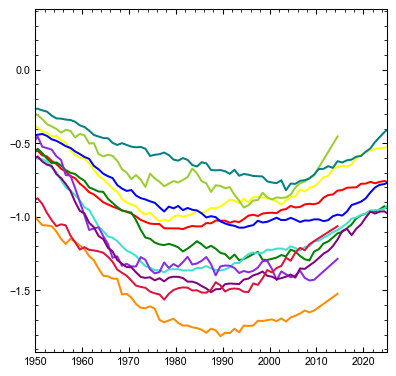

In [11]:
for model in models:
    pl.plot(np.arange(startyear[model]+0.5,endyear[model]+1), savgol_filter(cubes[model]['erf'].data,11,1), color=colors[model])
pl.xlim(1950,2025)

In [12]:
for model in models:
    df = pd.DataFrame()
    df['year'] = np.arange(startyear[model]+0.5, endyear[model]+1)
    for var in ['erf', 'erf_sw', 'erf_lw','aprp_ERFariSW', 'aprp_ERFaciSW', 'aprp_ERFariLW', 'aprp_ERFaciLW', 'aprp_albedo',
                'aprp_t9']:
        df[var] = cubes[model][var].data
    df.set_index('year', inplace=True)
    df.to_csv('../data_output/rfmip_aprp/%s.csv' % model)

In [13]:
# grab rcmip emissions dataset
check_and_download('../data_input/rcmip/rcmip-emissions-annual-means-v5-1-0.csv', 'https://rcmip-protocols-au.s3-ap-southeast-2.amazonaws.com/v5.1.0/rcmip-emissions-annual-means-v5-1-0.csv')

In [14]:
emissions = pd.read_csv('../data_input/rcmip/rcmip-emissions-annual-means-v5-1-0.csv')
df_emissions = pd.concat([emissions.loc[(
        (emissions.Variable=='Emissions|BC')|
        (emissions.Variable=='Emissions|OC')|
        (emissions.Variable=='Emissions|Sulfur')|
        (emissions.Variable=='Emissions|NOx')|
        (emissions.Variable=='Emissions|NH3')
    ) & (emissions.Scenario=='ssp245') & (emissions.Region=='World'), 'Variable'], emissions.loc[(
        (emissions.Variable=='Emissions|BC')|
        (emissions.Variable=='Emissions|OC')|
        (emissions.Variable=='Emissions|Sulfur')|
        (emissions.Variable=='Emissions|NOx')|
        (emissions.Variable=='Emissions|NH3')
    ) & (emissions.Scenario=='ssp245') & (emissions.Region=='World'), '1750':'2100']], axis=1)#.interpolate(axis=1).T
df_emissions.set_index('Variable', inplace=True)
df_emissions = df_emissions.interpolate(axis=1).T
df_emissions.rename(
    columns={
        'Emissions|BC': 'BC',
        'Emissions|OC': 'OC',
        'Emissions|Sulfur': 'SO2',
        'Emissions|NOx': 'NOx',
        'Emissions|NH3': 'NH3',
    }, inplace=True
)
# only keep cols we want
emissions = df_emissions[['SO2', 'BC', 'OC', 'NH3', 'NOx']]
emissions.index = emissions.index.astype('int')
emissions.index.name='year'
emissions.columns.name=None

In [15]:
emissions

,SO2,BC,OC,NH3,NOx
year,,,,,
1750,2.440048,2.097771,15.447668,6.927690,12.735212
1751,2.408379,2.072926,15.188717,6.860142,12.592303
1752,2.397116,2.064312,15.034476,6.819482,12.594270
1753,2.410693,2.071951,15.182545,6.881439,12.539820
1754,2.462065,2.099350,15.558773,7.015189,12.636837
...,...,...,...,...,...
2096,31.757785,2.800165,15.001741,66.175403,79.831397
2097,31.523938,2.762863,14.886222,65.973947,79.296580
2098,31.290090,2.725561,14.770703,65.772490,78.761762


In [16]:
def aerocom(x, bc, oc, so2):
    return bc*x[0] + oc*x[1] + so2*x[2]

def ghan(x, beta, n0, n1):
    return -beta*np.log(1 + x[0]/n0 + x[1]/n1)

coeff = {}

In [17]:
for model in models:
    coeff[model] = {}

    coeff[model]['ERFari'] = {}
    p, cov = curve_fit(
        aerocom, 
        emissions.loc[str(startyear[model]):str(endyear[model]), ['BC','OC','SO2']].values.T
           -emissions.loc['1850':'1850', ['BC','OC','SO2']].values.T,
        cubes[model]['aprp_ERFariSW'].data+cubes[model]['aprp_ERFariLW'].data,
        #bounds = ((0, -np.inf, -np.inf), (np.inf, np.inf, 0))
    )
    coeff[model]['ERFari']['BC'] = p[0]
    coeff[model]['ERFari']['OC'] = p[1]
    coeff[model]['ERFari']['SO2'] = p[2]
    

    coeff[model]['ERFaci'] = {}
    p, cov = curve_fit(
        ghan, 
        [
            emissions.loc[str(startyear[model]):str(endyear[model]), 'SO2'].values.T-emissions.loc['1850':'1850', 'SO2'].values.T,
            (
                emissions.loc[str(startyear[model]):str(endyear[model]), 'BC'].values.T-emissions.loc['1850':'1850', 'BC'].values.T+
                emissions.loc[str(startyear[model]):str(endyear[model]), 'OC'].values.T-emissions.loc['1850':'1850', 'OC'].values.T
            )
        ],
        cubes[model]['aprp_ERFaciSW'].data+cubes[model]['aprp_ERFaciLW'].data,#-cubes[model]['aprp_ERFariSW'].data,
        #bounds = ((0, 10), (np.inf, np.inf))
    )
    coeff[model]['ERFaci']['beta'] = p[0]
    coeff[model]['ERFaci']['n0']   = p[1]
    coeff[model]['ERFaci']['n1']   = p[2]

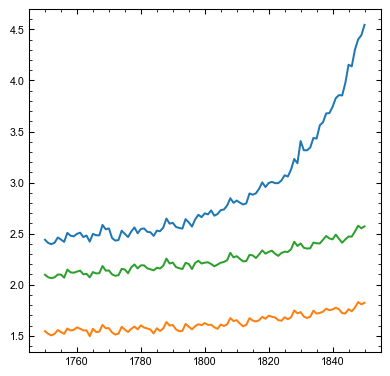

In [18]:
pl.plot(emissions.loc[1750:1850, 'SO2'])
pl.plot(emissions.loc[1750:1850, 'OC']/10)
pl.plot(emissions.loc[1750:1850, 'BC'])

In [19]:
emulated = {}
for model in models:
    emulated[model] = {}
    emulated[model]['ERFari'] = aerocom(emissions.loc['1750':'2100', ['BC','OC','SO2']].values.T-emissions.loc['1850':'1850', ['BC','OC','SO2']].values.T, coeff[model]['ERFari']['BC'], coeff[model]['ERFari']['OC'], coeff[model]['ERFari']['SO2'])
    emulated[model]['ERFaci'] = ghan([
        emissions.loc['1750':'2100', 'SO2'].values.T-emissions.loc['1850':'1850', 'SO2'].values.T, 
        emissions.loc['1750':'2100', ['BC','OC']].sum(axis=1).values.T-emissions.loc['1850':'1850', ['BC','OC']].sum(axis=1).values.T
    ], coeff[model]['ERFaci']['beta'], coeff[model]['ERFaci']['n0'], coeff[model]['ERFaci']['n1'])

In [20]:
emulated['mean'] = {}
nmodels = len(models)
for quantity in ['ERFari', 'ERFaci']:
    tally = np.zeros((351))
    for i, model in enumerate(models):
        tally = tally + emulated[model][quantity]
    emulated['mean'][quantity] = tally/nmodels

In [21]:
coeff['mean'] = {}

coeff['mean']['ERFari'] = {}
p, cov = curve_fit(
    aerocom, 
    emissions.loc['1850':'2100', ['BC','OC','SO2']].values.T
       -emissions.loc['1850':'1850', ['BC','OC','SO2']].values.T,
    emulated['mean']['ERFari'][100:],
#    bounds = ((0, -np.inf, -np.inf), (np.inf, np.inf, 0))
)
coeff['mean']['ERFari']['BC'] = p[0]
coeff['mean']['ERFari']['OC'] = p[1]
coeff['mean']['ERFari']['SO2'] = p[2]

coeff['mean']['ERFaci'] = {}
p, cov = curve_fit(
    ghan, 
    [
        emissions.loc['1850':'2100', 'SO2'].values.T-emissions.loc['1850':'1850', 'SO2'].values.T,
        emissions.loc['1850':'2100', ['BC','OC']].sum(axis=1).values.T-emissions.loc['1850':'1850', ['BC','OC']].sum(axis=1).values.T
#        emissions.loc['1850':'2100', 'OC'].values.T-emissions.loc['1850':'1850', 'OC'].values.T
    ],
    emulated['mean']['ERFaci'][100:],
#    bounds = ((0, 10), (np.inf, 120))
)
coeff['mean']['ERFaci']['beta'] = p[0]
coeff['mean']['ERFaci']['n0']   = p[1]
coeff['mean']['ERFaci']['n1']   = p[2]

In [22]:
emulated['mean_emulation'] = {}
emulated['mean_emulation']['ERFari'] = aerocom(emissions.loc['1750':'2100', ['BC','OC','SO2']].values.T-emissions.loc['1850':'1850', ['BC','OC','SO2']].values.T, coeff['mean']['ERFari']['BC'], coeff['mean']['ERFari']['OC'], coeff['mean']['ERFari']['SO2'])
emulated['mean_emulation']['ERFaci'] = ghan([
    emissions.loc['1750':'2100', 'SO2'].values.T-emissions.loc['1850':'1850', 'SO2'].values.T, 
    emissions.loc['1750':'2100', ['BC','OC']].sum(axis=1).values.T-emissions.loc['1850':'1850', ['BC','OC']].sum(axis=1).values.T
    #emissions.loc['1750':'2100', 'OC'].values.T-emissions.loc['1850':'1850', 'OC'].values.T
], coeff['mean']['ERFaci']['beta'], coeff['mean']['ERFaci']['n0'], coeff['mean']['ERFaci']['n1'])

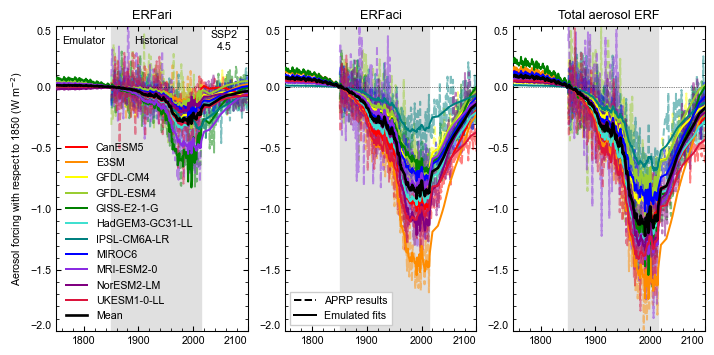

In [23]:
fig, ax = pl.subplots(1,3,figsize=(19/2.54,9.5/2.54), squeeze=False)
for model in models:
    ax[0,0].set_title('ERFari')
    ax[0,0].plot(np.arange(startyear[model]+0.5,endyear[model]+1), cubes[model]['aprp_ERFariSW'].data + cubes[model]['aprp_ERFariLW'].data, color=colors[model], ls='--', alpha=0.5)
    ax[0,0].plot(np.arange(1750,2101), emulated[model]['ERFari'], color=colors[model], label=model, zorder=7)
    ax[0,1].set_title('ERFaci')
    ax[0,1].plot(np.arange(startyear[model]+0.5,endyear[model]+1), cubes[model]['aprp_ERFaciSW'].data+cubes[model]['aprp_ERFaciLW'].data, 
                 color=colors[model], ls='--', alpha=0.5)
    ax[0,1].plot(np.arange(1750,2101), emulated[model]['ERFaci'], color=colors[model], zorder=7)
    ax[0,2].set_title('Total aerosol ERF')
    ax[0,2].plot(np.arange(startyear[model]+0.5,endyear[model]+1), cubes[model]['aprp_ERFariSW'].data+cubes[model]['aprp_ERFaciSW'].data+cubes[model]['aprp_ERFariLW'].data+cubes[model]['aprp_ERFaciLW'].data, 
                 color=colors[model], ls='--', alpha=0.5)
    ax[0,2].plot(np.arange(1750,2101), emulated[model]['ERFari']+emulated[model]['ERFaci'], color=colors[model], zorder=7)
ax[0,0].plot(np.arange(1750,2101), emulated['mean']['ERFari'], color=colors['mean'], label='Mean', lw=2, zorder=7)
ax[0,1].plot(np.arange(1750,2101), emulated['mean']['ERFaci'], color=colors['mean'], lw=2, zorder=7)
ax[0,2].plot(np.arange(1750,2101), emulated['mean']['ERFari']+emulated['mean']['ERFaci'], color=colors['mean'], lw=2, zorder=7)
ax[0,0].set_xlim(1750,2100)
ax[0,1].set_xlim(1750,2100)
ax[0,2].set_xlim(1750,2100)
ax[0,0].set_ylabel('Aerosol forcing with respect to 1850 (W m$^{-2}$)')
#ax[0,1].set_ylabel('ERFaci with respect to 1850')
ax[0,0].legend(framealpha=1, loc='lower left', fancybox=False, frameon=False)
ax[0,0].set_ylim(-2.0, 0.5)
ax[0,1].set_ylim(-2.0, 0.5)
ax[0,2].set_ylim(-2.0, 0.5)

ax[0,0].axhline(0, lw=0.5, ls=':', color='k')
ax[0,1].axhline(0, lw=0.5, ls=':', color='k')
ax[0,2].axhline(0, lw=0.5, ls=':', color='k')
#ax[0,0].axvline(2014.5, lw=0.5, color='#c0c0c0')
ax[0,0].fill_between(np.arange(1850,2015),-10,10, color='#e0e0e0', zorder=-20)
ax[0,1].fill_between(np.arange(1850,2015),-10,10, color='#e0e0e0', zorder=-20)
ax[0,2].fill_between(np.arange(1850,2015),-10,10, color='#e0e0e0', zorder=-20)

ax[0,0].text(1800, 0.38, 'Emulator', ha='center', va='center')
ax[0,0].text(0.5*(1850+2015), 0.38, 'Historical', ha='center', va='center')
ax[0,0].text(0.5*(2015+2100), 0.38, 'SSP2\n4.5', ha='center', va='center')


#ax[0,0].set_xticks(np.arange(1750,2101,50))
ax[0,0].get_xticklabels()[-1].set_ha("right")
ax[0,1].get_xticklabels()[-1].set_ha("right")
ax[0,2].get_xticklabels()[-1].set_ha("right")

ax[0,0].get_yticklabels()[-1].set_va("top")
ax[0,1].get_yticklabels()[-1].set_va("top")
ax[0,2].get_yticklabels()[-1].set_va("top")

ax[0,0].get_yticklabels()[0].set_va("bottom")
ax[0,1].get_yticklabels()[0].set_va("bottom")
ax[0,2].get_yticklabels()[0].set_va("bottom")

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='k', ls='--'),
                Line2D([0], [0], color='k', ls='-')]

ax[0,1].legend(custom_lines, ['APRP results', 'Emulated fits'], framealpha=1, loc='lower left', fancybox=False)
fig.tight_layout()

## What is different to cell above?

- take back to 1750
- don't plot the raw model APRP results

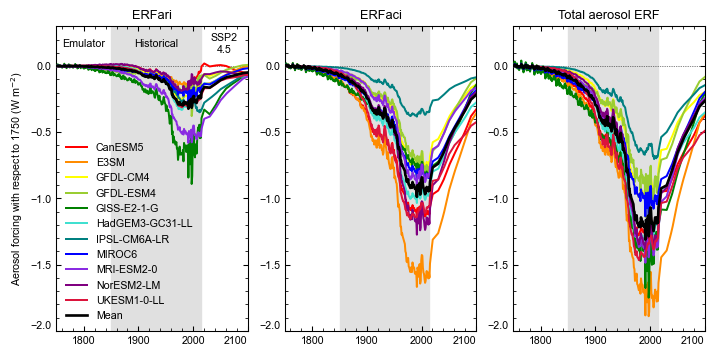

In [24]:
fig, ax = pl.subplots(1,3,figsize=(19/2.54,9.5/2.54), squeeze=False)
for model in models:
    ax[0,0].set_title('ERFari')
    ax[0,0].plot(np.arange(1750.5,2101), emulated[model]['ERFari']-emulated[model]['ERFari'][0], color=colors[model], label=model, zorder=7)
    ax[0,1].set_title('ERFaci')
    ax[0,1].plot(np.arange(1750.5,2101), emulated[model]['ERFaci']-emulated[model]['ERFaci'][0], color=colors[model], zorder=7)
    ax[0,2].set_title('Total aerosol ERF')
    ax[0,2].plot(np.arange(1750.5,2101), emulated[model]['ERFari']+emulated[model]['ERFaci']-(emulated[model]['ERFari']+emulated[model]['ERFaci'])[0], color=colors[model], zorder=7)
ax[0,0].plot(np.arange(1750.5,2101), emulated['mean']['ERFari']-emulated['mean']['ERFari'][0], color=colors['mean'], label='Mean', lw=2, zorder=7)
ax[0,1].plot(np.arange(1750.5,2101), emulated['mean']['ERFaci']-emulated['mean']['ERFaci'][0], color=colors['mean'], lw=2, zorder=7)
ax[0,2].plot(np.arange(1750.5,2101), emulated['mean']['ERFari']+emulated['mean']['ERFaci']-(emulated['mean']['ERFari']+emulated['mean']['ERFaci'])[0], color=colors['mean'], lw=2, zorder=7)
ax[0,0].set_xlim(1750,2100)
ax[0,1].set_xlim(1750,2100)
ax[0,2].set_xlim(1750,2100)
ax[0,0].set_ylabel('Aerosol forcing with respect to 1750 (W m$^{-2}$)')
#ax[0,1].set_ylabel('ERFaci with respect to 1850')
ax[0,0].legend(framealpha=1, loc='lower left', frameon=False)
ax[0,0].set_ylim(-2, 0.3)
ax[0,1].set_ylim(-2, 0.3)
ax[0,2].set_ylim(-2, 0.3)

ax[0,0].axhline(0, lw=0.5, ls=':', color='k')
ax[0,1].axhline(0, lw=0.5, ls=':', color='k')
ax[0,2].axhline(0, lw=0.5, ls=':', color='k')
#ax[0,0].axvline(2014.5, lw=0.5, color='#c0c0c0')
ax[0,0].fill_between(np.arange(1850,2015),-10,10, color='#e0e0e0', zorder=-20)
ax[0,1].fill_between(np.arange(1850,2015),-10,10, color='#e0e0e0', zorder=-20)
ax[0,2].fill_between(np.arange(1850,2015),-10,10, color='#e0e0e0', zorder=-20)

ax[0,0].text(1800, 0.17, 'Emulator', ha='center', va='center')
ax[0,0].text(0.5*(1850+2015), 0.17, 'Historical', ha='center', va='center')
ax[0,0].text(0.5*(2015+2100), 0.17, 'SSP2\n4.5', ha='center', va='center')


#ax[0,0].set_xticks(np.arange(1750,2101,50))
ax[0,0].get_xticklabels()[-1].set_ha("right")
ax[0,1].get_xticklabels()[-1].set_ha("right")
ax[0,2].get_xticklabels()[-1].set_ha("right")

ax[0,0].get_yticklabels()[-1].set_va("top")
ax[0,1].get_yticklabels()[-1].set_va("top")
ax[0,2].get_yticklabels()[-1].set_va("top")

ax[0,0].get_yticklabels()[0].set_va("bottom")
ax[0,1].get_yticklabels()[0].set_va("bottom")
ax[0,2].get_yticklabels()[0].set_va("bottom")

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='k', ls='--'),
                Line2D([0], [0], color='k', ls='-')]

#ax[0,1].legend(custom_lines, ['APRP results', 'Emulated fits'], framealpha=1, loc='lower left', frameon=False)
fig.tight_layout()
pl.savefig('../figures/figure3.png', dpi=300)
pl.savefig('../figures/figure3.pdf')

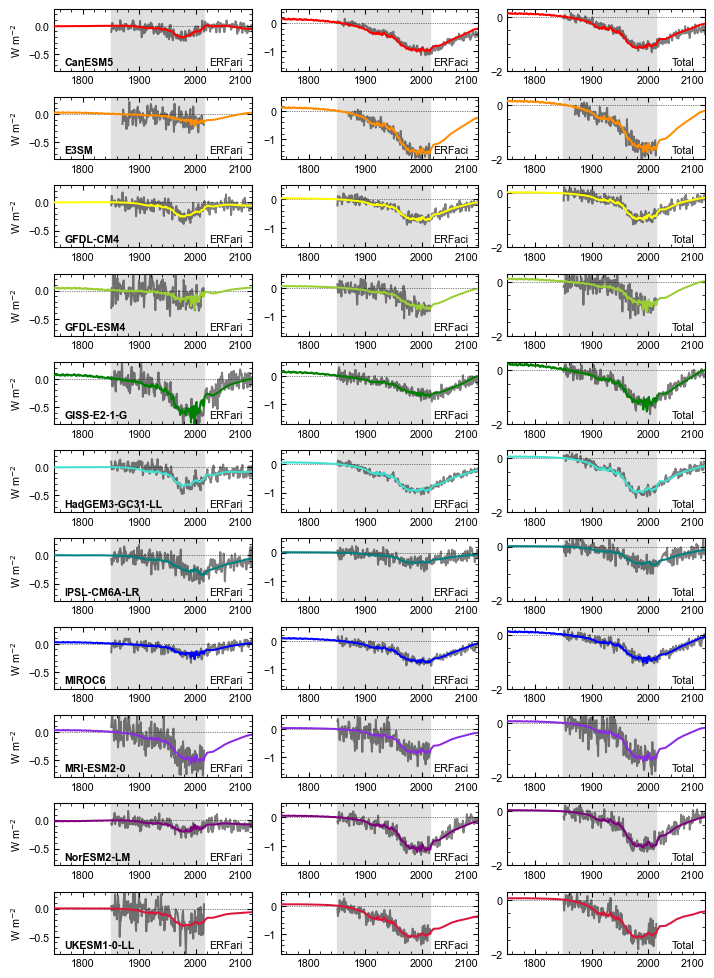

In [25]:
fig, ax = pl.subplots(11,3,figsize=(19/2.54,26/2.54), squeeze=False)
for i, model in enumerate(models):
#    ax[i,0].set_title('%s ERFari' % model)
    ax[i,0].plot(np.arange(startyear[model]+0.5,endyear[model]+1), cubes[model]['aprp_ERFariSW'].data + cubes[model]['aprp_ERFariLW'].data, color='k', ls='-', alpha=0.5, label=model)
    ax[i,0].plot(np.arange(1750.5,2101), emulated[model]['ERFari'], color=colors[model], label=model, zorder=7)
#    ax[i,1].set_title('%s ERFaci' % model)
    ax[i,1].plot(np.arange(startyear[model]+0.5,endyear[model]+1), cubes[model]['aprp_ERFaciSW'].data+cubes[model]['aprp_ERFaciLW'].data, 
                 color='k', ls='-', alpha=0.5)
    ax[i,1].plot(np.arange(1750.5,2101), emulated[model]['ERFaci'], color=colors[model], zorder=7)
#    ax[i,2].set_title('%s aerosol ERF' % models)
    ax[i,2].plot(np.arange(startyear[model]+0.5,endyear[model]+1), cubes[model]['aprp_ERFariSW'].data+cubes[model]['aprp_ERFaciSW'].data+cubes[model]['aprp_ERFariLW'].data+cubes[model]['aprp_ERFaciLW'].data, 
                 color='k', ls='-', alpha=0.5)
    ax[i,2].plot(np.arange(1750.5,2101), emulated[model]['ERFari']+emulated[model]['ERFaci'], color=colors[model], zorder=7)
    ax[i,0].set_xlim(1750,2100)
    ax[i,1].set_xlim(1750,2100)
    ax[i,2].set_xlim(1750,2100)
#    ax[i,0].set_ylabel('Aerosol forcing with respect to 1850 (W m$^{-2}$)')
    ax[i,0].set_ylim(-0.8, 0.3)
    ax[i,1].set_ylim(-1.7, 0.5)
    ax[i,2].set_ylim(-2.0, 0.3)
    ax[i,0].axhline(0, lw=0.5, ls=':', color='k')
    ax[i,1].axhline(0, lw=0.5, ls=':', color='k')
    ax[i,2].axhline(0, lw=0.5, ls=':', color='k')
    ax[i,0].fill_between(np.arange(1850,2015),-10,10, color='#e0e0e0', zorder=-20)
    ax[i,1].fill_between(np.arange(1850,2015),-10,10, color='#e0e0e0', zorder=-20)
    ax[i,2].fill_between(np.arange(1850,2015),-10,10, color='#e0e0e0', zorder=-20)
    ax[i,0].get_xticklabels()[-1].set_ha("right")
    ax[i,1].get_xticklabels()[-1].set_ha("right")
    ax[i,2].get_xticklabels()[-1].set_ha("right")
    #ax[i,0].legend(loc='lower left', frameon=False)
    ax[i,0].text(0.05,0.09,model,transform=ax[i,0].transAxes, fontweight='bold')
    ax[i,0].text(0.95,0.09,'ERFari',transform=ax[i,0].transAxes, ha='right')
    ax[i,1].text(0.95,0.09,'ERFaci',transform=ax[i,1].transAxes, ha='right')
    ax[i,2].text(0.95,0.09,'Total',transform=ax[i,2].transAxes, ha='right')
    ax[i,0].set_ylabel('W m$^{-2}$')


fig.tight_layout()
pl.savefig('../figures/figure2.png', dpi=300)
pl.savefig('../figures/figure2.pdf')

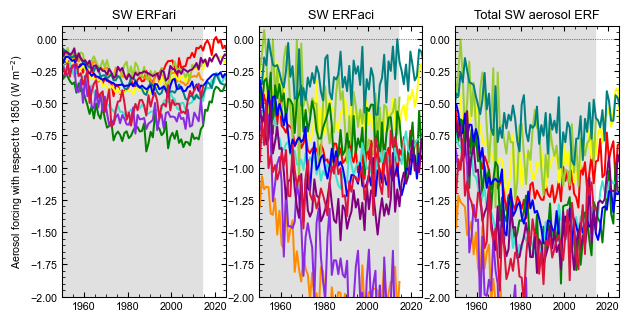

In [26]:
fig, ax = pl.subplots(1,3,figsize=(19/2.54,9.5/2.54), squeeze=False)
for model in models:
    ax[0,0].set_title('SW ERFari')
    ax[0,0].plot(np.arange(startyear[model]+0.5,endyear[model]+1), cubes[model]['aprp_ERFariSW'].data, color=colors[model])
    ax[0,1].set_title('SW ERFaci')
    ax[0,1].plot(np.arange(startyear[model]+0.5,endyear[model]+1), cubes[model]['aprp_ERFaciSW'].data, color=colors[model])
    ax[0,2].set_title('Total SW aerosol ERF')
    ax[0,2].plot(np.arange(startyear[model]+0.5,endyear[model]+1), cubes[model]['aprp_ERFariSW'].data+cubes[model]['aprp_ERFaciSW'].data,
                 color=colors[model])
ax[0,0].set_xlim(1950,2025)
ax[0,1].set_xlim(1950,2025)
ax[0,2].set_xlim(1950,2025)
ax[0,0].set_ylabel('Aerosol forcing with respect to 1850 (W m$^{-2}$)')
ax[0,0].set_ylim(-2.0, 0.1)
ax[0,1].set_ylim(-2.0, 0.1)
ax[0,2].set_ylim(-2.0, 0.1)

ax[0,0].axhline(0, lw=0.5, ls=':', color='k')
ax[0,1].axhline(0, lw=0.5, ls=':', color='k')
ax[0,2].axhline(0, lw=0.5, ls=':', color='k')
#ax[0,0].axvline(2014.5, lw=0.5, color='#c0c0c0')
ax[0,0].fill_between(np.arange(1850,2015),-10,10, color='#e0e0e0', zorder=-20)
ax[0,1].fill_between(np.arange(1850,2015),-10,10, color='#e0e0e0', zorder=-20)
ax[0,2].fill_between(np.arange(1850,2015),-10,10, color='#e0e0e0', zorder=-20)

In [27]:
so2_samp_ari = np.zeros(len(models))
bc_samp_ari = np.zeros(len(models))
oc_samp_ari = np.zeros(len(models))
log_n0_samp = np.zeros(len(models))
log_n1_samp = np.zeros(len(models))
beta_samp = np.zeros(len(models))

for im, model in enumerate(models):
    print(model)
    print(coeff[model]['ERFari'])
    print(coeff[model]['ERFaci'])
    so2_samp_ari[im] = coeff[model]['ERFari']['SO2']
    bc_samp_ari[im] = coeff[model]['ERFari']['BC']
    oc_samp_ari[im] = coeff[model]['ERFari']['OC']
    beta_samp[im] = (coeff[model]['ERFaci']['beta'])
    log_n0_samp[im] = np.log(coeff[model]['ERFaci']['n0'])
    log_n1_samp[im] = np.log(coeff[model]['ERFaci']['n1'])

print()
print('SO2 mean', np.mean(so2_samp_ari))
print('BC mean', np.mean(bc_samp_ari))
print('OC mean', np.mean(oc_samp_ari)) # nice and linear!
print('SO2 std', np.std(so2_samp_ari))
print('BC std', np.std(bc_samp_ari))
print('OC std', np.std(oc_samp_ari))
print()
print('beta mean', np.mean(beta_samp))
print('nSO2 mean', np.mean(log_n0_samp))
print('nPOM mean', np.mean(log_n1_samp))
print('beta std', np.std(beta_samp))
print('log(nSO2) std', np.std(log_n0_samp))
print('log(nPOM) std', np.std(log_n1_samp))
print()

CanESM5
{'BC': 0.03259343948789619, 'OC': -0.0003466518603792783, 'SO2': -0.0024876158192160265}
{'beta': 0.7274280578509786, 'n0': 58.94825676543968, 'n1': 24.616575857824056}
E3SM
{'BC': 0.024823190264087823, 'OC': -0.012632191159433646, 'SO2': -0.0009420910115415229}
{'beta': 2.048199377261758, 'n0': 155.89801959815736, 'n1': 71.34331920753066}
GFDL-CM4
{'BC': 0.02685602162643198, 'OC': -0.002089503100112345, 'SO2': -0.0026057968480401746}
{'beta': 3.501476398134132, 'n0': 692.7345545753442, 'n1': 382.8960367600309}
GFDL-ESM4
{'BC': 0.10170074629567541, 'OC': -0.03041920333701193, 'SO2': -0.0026386847412556004}
{'beta': 2756.740612855589, 'n0': 813394.8293042568, 'n1': 180390.77478663376}
GISS-E2-1-G
{'BC': 0.14613221319782882, 'OC': -0.04414859961725643, 'SO2': -0.006678277836488548}
{'beta': 0.5630170696325686, 'n0': 117.8858877569476, 'n1': 16.034015705189493}
HadGEM3-GC31-LL
{'BC': 0.010268053466622911, 'OC': 0.00146618150497765, 'SO2': -0.002892076302344093}
{'beta': 1.00403020

In [28]:
with open("../data_output/cmip6_aerosol_coefficients.json", "w") as write_file:
    json.dump(coeff, write_file, indent=4)

In [29]:
erfaci = np.zeros(11)
for i, model in enumerate(models):
    erfaci[i] = np.mean(cubes[model]['aprp_ERFaciSW'].data[155:166]+cubes[model]['aprp_ERFaciLW'].data[155:166])

In [30]:
np.corrcoef([erfaci, log_n0_samp, log_n1_samp, so2_samp_ari, bc_samp_ari, oc_samp_ari])

array([[        nan,         nan,         nan,         nan,         nan,
                nan],
       [        nan,  1.        ,  0.96096296,  0.16216508,  0.05000793,
        -0.03362395],
       [        nan,  0.96096296,  1.        ,  0.29387718, -0.15320772,
         0.15929571],
       [        nan,  0.16216508,  0.29387718,  1.        , -0.77342086,
         0.7193733 ],
       [        nan,  0.05000793, -0.15320772, -0.77342086,  1.        ,
        -0.93804223],
       [        nan, -0.03362395,  0.15929571,  0.7193733 , -0.93804223,
         1.        ]])

In [31]:
kde = gaussian_kde([log_n0_samp, log_n1_samp])
aci_sample=kde.resample(size=100000, seed=63648708)
kde = gaussian_kde([so2_samp_ari, bc_samp_ari, oc_samp_ari])
ari_sample=kde.resample(size=100000, seed=685534562)

In [32]:
df = pd.DataFrame(aci_sample.T, columns=['log(n_SO2)', 'log(n_POM)'])
df.to_csv('../data_output/ERFaci_samples.csv', index=False)

df = pd.DataFrame(ari_sample.T, columns=['SO2', 'BC', 'OC'])
df.to_csv('../data_output/ERFari_samples.csv', index=False)

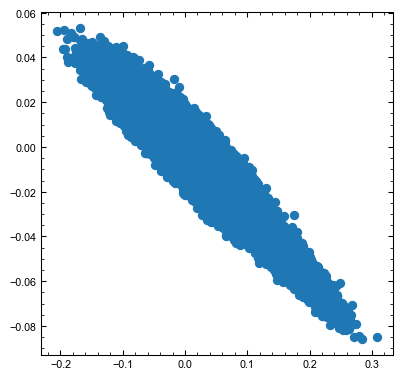

In [33]:
pl.scatter(ari_sample[1,:], ari_sample[2,:])

# df = pd.DataFrame(arisw_sample.T, columns=['SO2 SW', 'BC SW', 'OC SW', 'SO2 LW', 'BC LW', 'OC LW'])
# df.to_csv('../data/ERFari_samples.csv', index=False)
    
# df = pd.DataFrame(acisw_sample.T, columns=['ERFaciSW 2010', 'log(n_SO2)', 'log(n_POM)', 'SO2 LW', 'BC LW', 'OC LW'])
# df.to_csv('../data/ERFaci_samples.csv', index=False)

In [34]:
print(coeff['mean']['ERFari'])
print(coeff['mean']['ERFaci'])

{'BC': 0.028518986645677466, 'OC': -0.008524786029251549, 'SO2': -0.0025287384767031626}
{'beta': 1.2227700268727806, 'n0': 156.47861185879586, 'n1': 76.67556157572014}


In [35]:
# 1850 start emulations
emulator = np.zeros((351,11))
for i, model in enumerate(models):
    emulator[:,i] = emulated[model]['ERFari']+emulated[model]['ERFaci']
df = pd.DataFrame(emulator, columns=models)
df['year'] = np.arange(1750,2101)
df.set_index('year', inplace=True)
df.to_csv('../data_output/erf_aer_emulations.csv')

In [36]:
# 1750 start emulations = figure 3 data
erfari_emulator = np.zeros((351, 11))
erfaci_emulator = np.zeros((351, 11))
erfaer_emulator = np.zeros((351, 11))

for i, model in enumerate(models):
    erfari_emulator[:, i] = emulated[model]['ERFari']-emulated[model]['ERFari'][0]
    erfaci_emulator[:, i] = emulated[model]['ERFaci']-emulated[model]['ERFaci'][0]
    erfaer_emulator[:, i] = erfari_emulator[:, i] + erfaci_emulator[:, i]
    
df = pd.DataFrame(erfari_emulator, columns=models)
df['year'] = np.arange(1750,2101)
df.set_index('year', inplace=True)
df.to_csv('../data_output/fig3a_emulations.csv')

df = pd.DataFrame(erfaci_emulator, columns=models)
df['year'] = np.arange(1750,2101)
df.set_index('year', inplace=True)
df.to_csv('../data_output/fig3b_emulations.csv')

df = pd.DataFrame(erfaer_emulator, columns=models)
df['year'] = np.arange(1750,2101)
df.set_index('year', inplace=True)
df.to_csv('../data_output/fig3c_emulations.csv')

In [37]:
print (np.min(ari_sample[2,:]), np.max(ari_sample[2,:]))

-0.08589342779462095 0.05320591042268576


In [38]:
ari_sample[0,:].shape

(100000,)

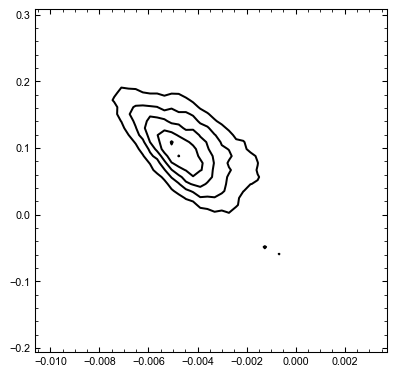

In [39]:
z, x, y = np.histogram2d(ari_sample[0,:], ari_sample[1,:], bins=50)
z[z==0] = np.nan
contours = pl.contour(z,extent=[x.min(),x.max(),y.min(),y.max()], levels=5, colors='black')
#pl.clabel(contours, inline=True, fontsize=8)0

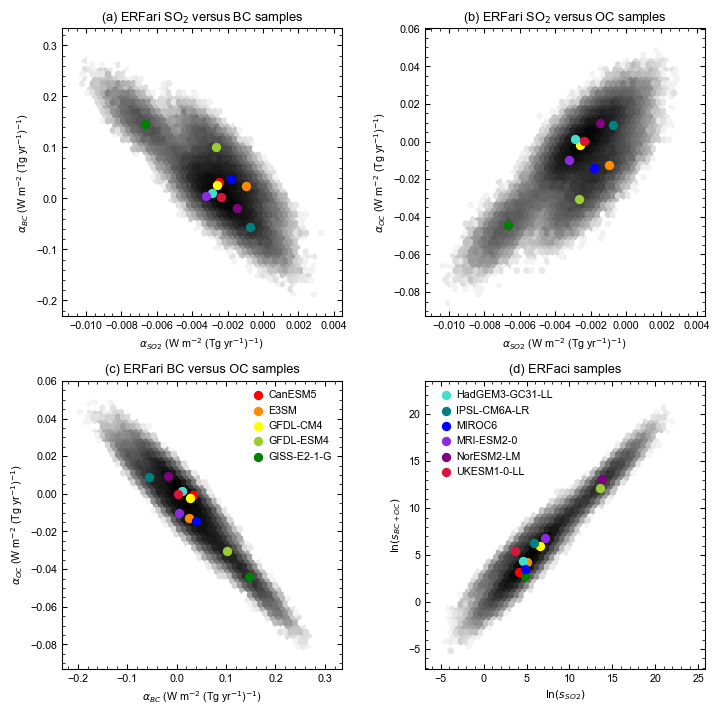

In [40]:
fig = pl.figure(figsize=(19/2.54,19/2.54))

ax = fig.add_subplot(221)
#ax.scatter(ari_sample[0,:], ari_sample[1,:], alpha=0.02, color='k')
ax.hexbin(ari_sample[0,:], ari_sample[1,:], cmap='Greys',  bins='log', gridsize=50)
#contours = ax.contour(z,extent=[x.min(),x.max(),y.min(),y.max()], levels=5, colors='black')
ax.set_xlabel(r'$\alpha_{SO2}$ (W m$^{-2}$ (Tg yr$^{-1}$)$^{-1}$)')
ax.set_ylabel(r'$\alpha_{BC}$ (W m$^{-2}$ (Tg yr$^{-1}$)$^{-1}$)')
for model in models:
    ax.scatter(coeff[model]['ERFari']['SO2'], coeff[model]['ERFari']['BC'], color=colors[model], label=model, alpha=1)
ax.set_title('(a) ERFari SO$_2$ versus BC samples')

ax = fig.add_subplot(222)
#ax.scatter(ari_sample[0,:], ari_sample[2,:], alpha=0.02, color='k')
ax.hexbin(ari_sample[0,:], ari_sample[2,:], cmap='Greys',  bins='log', gridsize=50)
ax.set_xlabel(r'$\alpha_{SO2}$ (W m$^{-2}$ (Tg yr$^{-1}$)$^{-1}$)')
ax.set_ylabel(r'$\alpha_{OC}$ (W m$^{-2}$ (Tg yr$^{-1}$)$^{-1}$)')
for model in models:
    ax.scatter(coeff[model]['ERFari']['SO2'], coeff[model]['ERFari']['OC'], color=colors[model], label=model, alpha=1)
ax.set_title('(b) ERFari SO$_2$ versus OC samples')

ax = fig.add_subplot(223)
#ax.scatter(ari_sample[1,:], ari_sample[2,:], alpha=0.02, color='k')
ax.hexbin(ari_sample[1,:], ari_sample[2,:], cmap='Greys',  bins='log', gridsize=50)
for i, model in enumerate(models):
    if i<5:
        label = model
    else:
        label = ''
    ax.scatter(coeff[model]['ERFari']['BC'], coeff[model]['ERFari']['OC'], color=colors[model], label=label, alpha=1)
ax.set_title('(c) ERFari BC versus OC samples')
ax.set_xlabel(r'$\alpha_{BC}$ (W m$^{-2}$ (Tg yr$^{-1}$)$^{-1}$)')
ax.set_ylabel(r'$\alpha_{OC}$ (W m$^{-2}$ (Tg yr$^{-1}$)$^{-1}$)')
ax.legend(frameon=False, handletextpad=0.02)
    
ax = fig.add_subplot(224)
#ax.scatter(aci_sample[0,:],aci_sample[1,:], alpha=0.02, color='k')
ax.hexbin(aci_sample[0,:],aci_sample[1,:], cmap='Greys',  bins='log', gridsize=50)
ax.set_xlabel(r'$\ln(s_{SO2})$')
ax.set_ylabel(r'$\ln(s_{BC+OC})$')
for i, model in enumerate(models):
    if i<5:
        label = ''
    else:
        label = model
    ax.scatter(np.log(coeff[model]['ERFaci']['n0']), np.log(coeff[model]['ERFaci']['n1']), color=colors[model], label=label)
ax.set_title('(d) ERFaci samples')
ax.legend(frameon=False, handletextpad=0.02)

fig.tight_layout()
pl.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)
pl.savefig('../figures/figure4.png', dpi=300)
pl.savefig('../figures/figure4.pdf')
#pl.show()